This notebook dig a little deeper than previous version. Differences are:

1) I try to understand the synthetic data more; <br>
2) I format the print out values better (define decimals); <br>
3) Find out how's the err (+/-) get calculated from solution for linear leaset square; <br>
4) understand better about results from scipy.optimize.minimize function;

In [56]:
# dependencies
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import corner
import pandas as pd

In [30]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

In [31]:
# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true

In [32]:
# check the y values now
y

array([ 3.9832498 ,  3.78878283,  3.57720151,  3.23468858,  2.9762121 ,
        2.66006371,  2.62099308,  2.60581615,  2.45734943,  2.39858959,
        2.32004824,  2.15143168,  2.04490304,  1.74655937,  1.71289738,
        1.70252768,  1.50099848,  1.09796476,  0.94001993,  0.56609861,
        0.38190695,  0.25395268,  0.24657806,  0.06255693, -0.074057  ,
       -0.10964826, -0.14758119, -0.29211992, -0.58554767, -0.6307897 ,
       -0.71514466, -0.94121597, -1.01338619, -1.10101195, -1.33242792,
       -1.62867499, -1.74797387, -1.83169068, -2.04448065, -2.33147943,
       -2.61386139, -2.98969828, -2.99458017, -4.10585542, -4.19295655,
       -4.24641341, -4.4401811 , -4.6449545 , -5.25049834, -5.29914235])

In [71]:
x

array([0.32390056, 0.52659701, 0.74713206, 1.10413948, 1.3735542 ,
       1.7030814 , 1.74380542, 1.75962461, 1.91437416, 1.97562061,
       2.05748568, 2.23323778, 2.34427451, 2.65524352, 2.69033002,
       2.70113854, 2.91119608, 3.33128543, 3.49591418, 3.88565916,
       4.07764546, 4.21101451, 4.21870121, 4.41050976, 4.55290494,
       4.59000236, 4.62954054, 4.78019588, 5.08604093, 5.13319751,
       5.22112223, 5.45676045, 5.53198477, 5.62331869, 5.86452775,
       6.17331143, 6.29765882, 6.38491836, 6.6067132 , 6.90585724,
       7.20018907, 7.59193066, 7.59701915, 8.75532147, 8.84610856,
       8.90182761, 9.10379519, 9.31723421, 9.94840353, 9.99910606])

In [73]:
data = pd.DataFrame({
    "X_values": x,
    "Y_values": y
})

In [75]:
data.to_csv("data.csv")

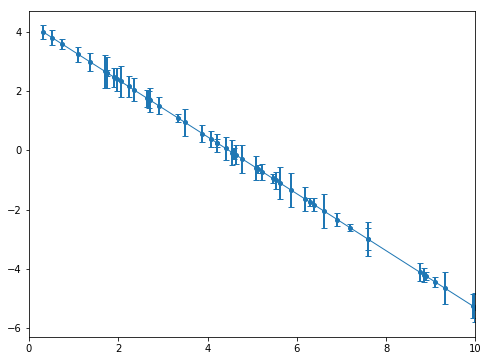

In [33]:
# plot the synthetic data
fig = plt.figure(figsize=(8,6))
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4, linewidth=1, linestyle='solid')
plt.xlim(0, 10)
plt.show()

In [36]:
# generate variation for y
y += np.abs(f_true*y) * np.random.randn(N)

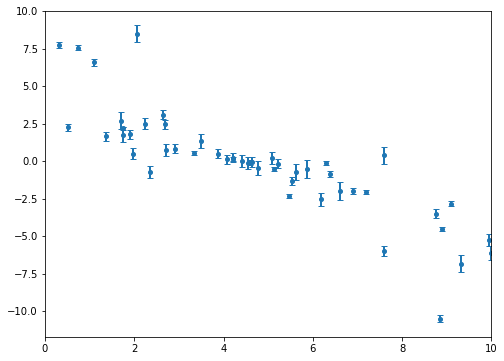

In [37]:
# plot the synthetic data
fig = plt.figure(figsize=(8,6))
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.savefig("synthetic_data.png")
plt.show()

In [38]:
# generate more variation for y
y += yerr * np.random.randn(N)

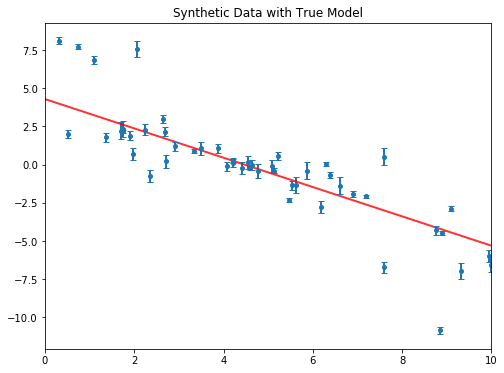

In [70]:
# plot the synthetic data along with perfect model
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.title("Synthetic Data with True Model")
plt.savefig("data_n_true.png")
plt.show()

In [41]:
# linear least squares solution to these data
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print(f"the results are: m={m_ls:.02f} and b={b_ls:.02f}")

the results are: m=-1.12 and b=5.28


In [42]:
cov

array([[ 0.00456364, -0.00073453],
       [-0.00073453,  0.00015372]])

In [43]:
err_xy = np.sqrt(np.diag(cov))

In [44]:
err_xy

array([0.06755471, 0.01239856])

In [45]:
print(f"the results are: m= {m_ls:.02f} +/- {err_xy[1]:.04f} and b= {b_ls:.02f} +/- {err_xy[0]:.04f}")

the results are: m= -1.12 +/- 0.0124 and b= 5.28 +/- 0.0676


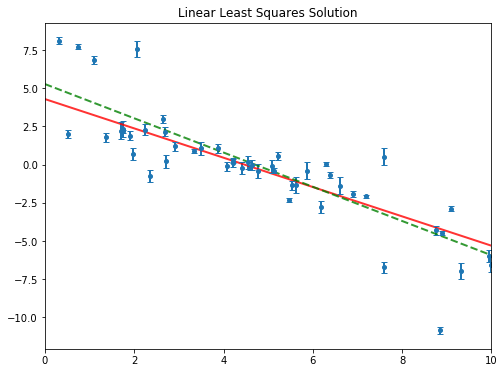

In [46]:
# plotted as a dashed green line
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="g", linestyle='dashed', lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.title("Linear Least Squares Solution")
plt.savefig("LLS_sol.png")
plt.show()

In [47]:
# likelihood function is simply a Gaussian where the variance is underestimated by some fractional amount: f. 
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [48]:
# finding this numerical optimum of this likelihood function using the scipy.optimize module
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print(f"current results are m={m_ml:.03f}, b={b_ml:.03f} and f={np.e**(lnf_ml):.03f}")
print(f"True values: m={m_true}, b={b_true} and f={f_true}")

current results are m=-0.991, b=4.409 and f=0.755
True values: m=-0.9594, b=4.294 and f=0.534


In [49]:
result

      fun: 36.501663252677204
 hess_inv: array([[ 0.01403846, -0.06244636,  0.0146894 ],
       [-0.06244636,  0.28500282, -0.06528608],
       [ 0.0146894 , -0.06528608,  0.02822885]])
      jac: array([9.53674316e-07, 4.76837158e-07, 4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 75
      nit: 11
     njev: 15
   status: 0
  success: True
        x: array([-0.99069459,  4.40922231, -0.28050328])

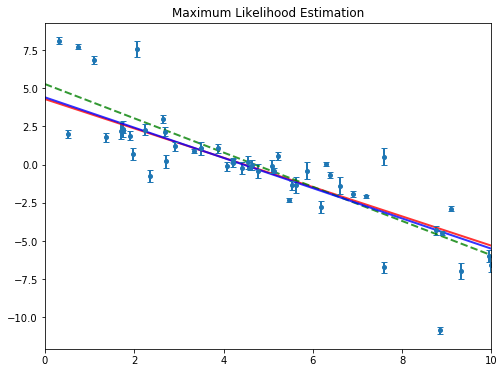

In [50]:
# plot all the data togther
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="g", linestyle='dashed', lw=2, alpha=0.8)
plt.plot(xl, m_ml*xl+b_ml, color="b", lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.title("Maximum Likelihood Estimation")
plt.savefig("Max_like.png")
plt.show()

In [51]:
# write down priors if you’re going to use MCMC. the log-prior
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [52]:
# combine above with lnlike function: the full log-probability function 
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [53]:
# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# set up the sampler using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [67]:
# run the MCMC for 500 steps
foo = sampler.run_mcmc(pos, 500)

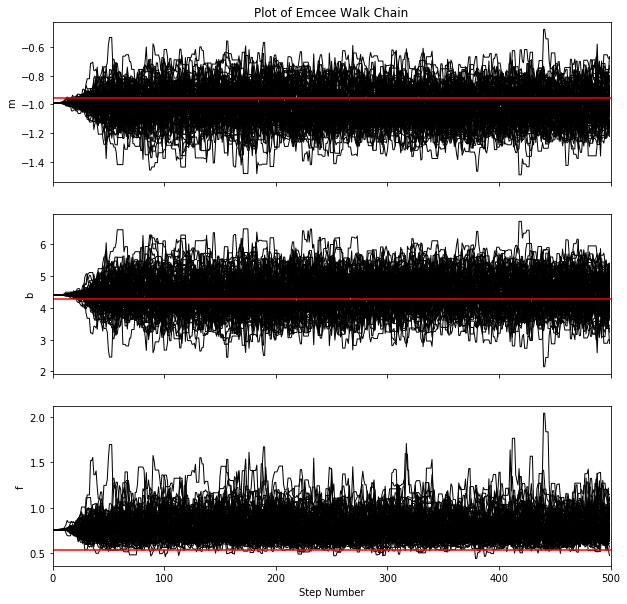

In [68]:
# plot positions of each walker as a function of the number of steps in the chain
x_axis = list(range(500))
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10,10))

for i in range(100):
    m_walk = []
    b_walk = []
    f_walk = []
    for j in range(500):
        m_walk.append(sampler.chain[i][j][0])
        b_walk.append(sampler.chain[i][j][1])
        f_walk.append(np.e**(sampler.chain[i][j][2]))
    ax1.plot(x_axis, m_walk, color='k', linewidth=1)
    ax2.plot(x_axis, b_walk, color='k', linewidth=1)
    ax3.plot(x_axis, f_walk, color='k', linewidth=1)
plt.xlim(0,500)
plt.xlabel("Step Number")
ax1.set_ylabel("m")
ax1.axhline(y=-0.9594, color='r', linestyle='-')
ax2.set_ylabel("b")
ax2.axhline(y=4.294, color='r', linestyle='-')
ax3.set_ylabel("f")
ax3.axhline(y=0.534, color='r', linestyle='-')
ax1.set_title("Plot of Emcee Walk Chain")
plt.savefig("walk_chain.png")
plt.show()

In [63]:
sampler.chain.shape

(100, 500, 3)

In [64]:
# discard the initial 50 steps (burnt-in) and flatten the chain
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

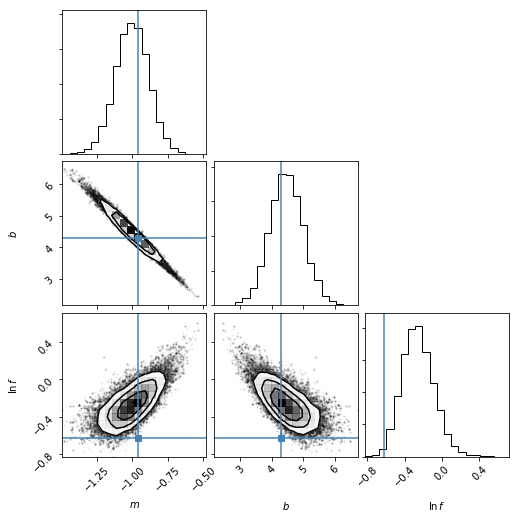

In [66]:
# based on MCMC results and generate a corner plot
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
# plt.title("Corner Plot of MCMC results")
plt.savefig("corner.png")
plt.show()


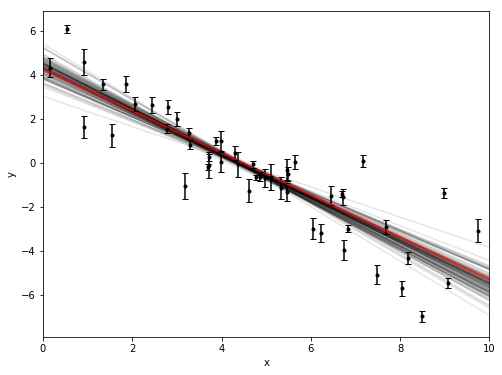

In [36]:
# choose a few (say 100 in this case) samples from the chain and plot them
fig = plt.figure(figsize=(8,6))
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=3)
plt.xlim(0,10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [37]:
# quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the 
# marginalized distributions
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [38]:
# print and compare results with true values
print(f"Final results: m={m_mcmc[0]:.4f}, b={b_mcmc[0]:.4f} and f={f_mcmc[0]:.4f}")
print(f"True values: m={m_true}, b={b_true} and f={f_true}")

Final results: m=-1.0057, b=4.4027 and f=0.5448
True values: m=-0.9594, b=4.294 and f=0.534
